In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

# Carrega a base de dados contendo os registros de importação de fertilizantes
q=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/q.csv')

# Formata coluna date para guiar o eixo x dos gráficos
q.date=pd.to_datetime(q.date)

# Recria as colunas de Ano e Mẽs para permitir visualização agrupada
q['CO_ANO']=q.date.dt.year
q['CO_MES']=q.date.dt.month

q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   kton             1428 non-null   float64       
 1   mm               1428 non-null   float64       
 2   date             1428 non-null   datetime64[ns]
 3   CO_MES_1         1428 non-null   bool          
 4   CO_MES_2         1428 non-null   bool          
 5   CO_MES_3         1428 non-null   bool          
 6   CO_MES_4         1428 non-null   bool          
 7   CO_MES_5         1428 non-null   bool          
 8   CO_MES_6         1428 non-null   bool          
 9   CO_MES_7         1428 non-null   bool          
 10  CO_MES_8         1428 non-null   bool          
 11  CO_MES_9         1428 non-null   bool          
 12  CO_MES_10        1428 non-null   bool          
 13  CO_MES_11        1428 non-null   bool          
 14  CO_MES_12        1428 non-null   bool   

In [2]:
# Seleciona as colunas necessárias
x=q.columns.tolist()
y=q.columns[3:15].tolist()
q=q[[item for item in x if item not in y]]

# Teste de hipótese:

Tratamento: Previsão de importação de fertilizantes considerando volumes de chuva como input adicional
Testemunha  : Previsão de importação de fertilizantes sem variável adcional

In [3]:
q=q.rename(columns={'erro_mm':'erro_tratm','erro_s_mm':'erro_testm'})

erro* = erro absoluto médio

* Ho = "O erro* do Tratamento não difere do erro* do Testemunha     ( erro_testemunha - erro_tratamento = 0 )"

* Ha = "O erro* do Tratamento é menor do que erro* do Testemunha    ( erro_testemunha - erro_tratamento > 0 )"

> Ha < Ho ==> "left-tailed test"

# Significance level

In [4]:
alpha=0.05

In [5]:
# Determina a diferença entre a média dos erros absolutos das importações em kilo ton/mês, com e sem o uso dos dados sobre chuva como _input_
q['dif_testm_tratm_kton_mês']=q.erro_testm-q.erro_tratm

Os anos de registros serão aqui considerados a repetição dos tratamentos.  

Da repetição espera-se que seja a mais isenta de tendência quanto possível.

Vejamos abaixo como a variável analisada comporta-se nas repetições.

In [6]:
# Define o estilo dos gráficos
plt.style.use('ggplot')

In [7]:
# Define o título dos gráficos
title='Superioridade do Erro do Testemunha'

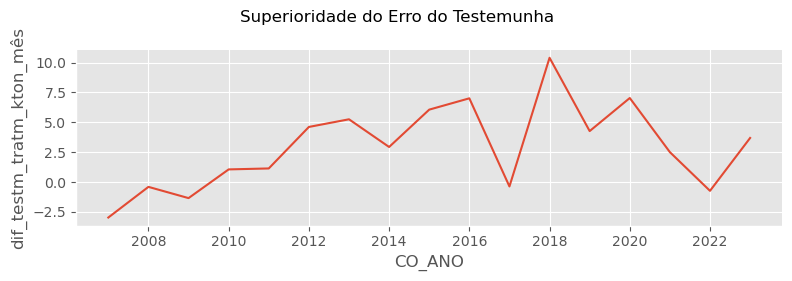

In [8]:
# Viauliza a variável anualizada
sns.relplot(data=q.groupby('CO_ANO').dif_testm_tratm_kton_mês.mean().reset_index(),x='CO_ANO',y='dif_testm_tratm_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

> O gráfico acima mostra uma fase com uma tendência de crescimento, e outra fase sem essa tendência. Em nome da homegeneidade das repetições, só serão considerados os registros da fase mais recente, tendo início no ano de 2012 inclusive.

In [9]:
q=q[q.CO_ANO>=2012]

Os meses, graças as estações do ano, são também tratamentos. Porém aqui desejamos comparar somente o tratamento referente a chuva. Assim, a seguir, selecionaremos para seguir em análise somente o mês de maior diferença entre o tratamento e o testemunha.

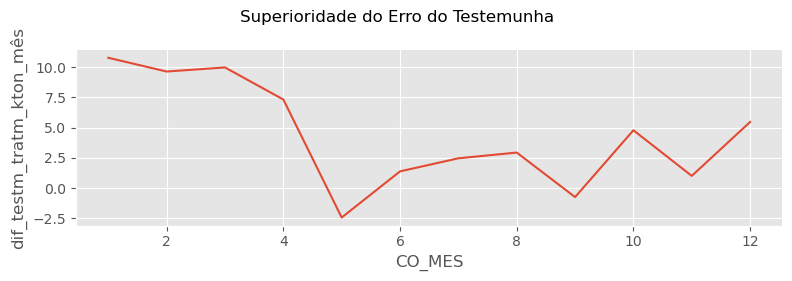

In [10]:
sns.relplot(data=q.groupby('CO_MES').dif_testm_tratm_kton_mês.mean().reset_index(),x='CO_MES',y='dif_testm_tratm_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

In [11]:
mes_pos=q.groupby('CO_MES').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').CO_MES.values[-1]
mes_pos

1

Selecionaremos também o mês de menor diferença entre o tratamento e a testemunha

In [12]:
mes_neg=q.groupby('CO_MES').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').CO_MES.values[0]
mes_neg

5

Da mesma forma se fará com os demais tratamentos

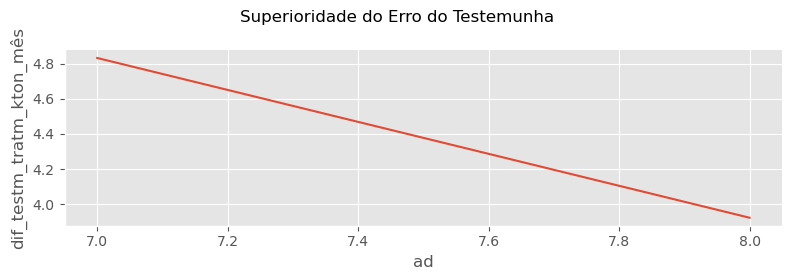

In [13]:
sns.relplot(data=q.groupby('ad').dif_testm_tratm_kton_mês.mean().reset_index(),x='ad',y='dif_testm_tratm_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

In [14]:
ad_pos=q.groupby('ad').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').ad.values[-1]
ad_pos

7

In [15]:
ad_neg=q.groupby('ad').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').ad.values[0]
ad_neg

8

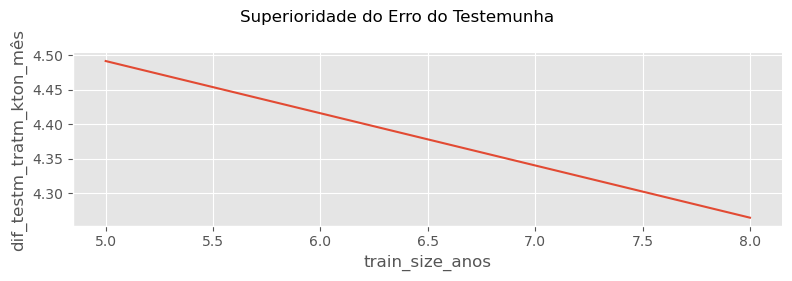

In [16]:
sns.relplot(data=q.groupby('train_size_anos').dif_testm_tratm_kton_mês.mean().reset_index(),x='train_size_anos',y='dif_testm_tratm_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

In [17]:
train_size_anos_pos=q.groupby('train_size_anos').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').train_size_anos.values[-1]
train_size_anos_pos

5.0

In [18]:
train_size_anos_neg=q.groupby('train_size_anos').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').train_size_anos.values[0]
train_size_anos_neg

8.0

Text(0.5, 1.1, 'Superioridade do Erro do Testemunha')

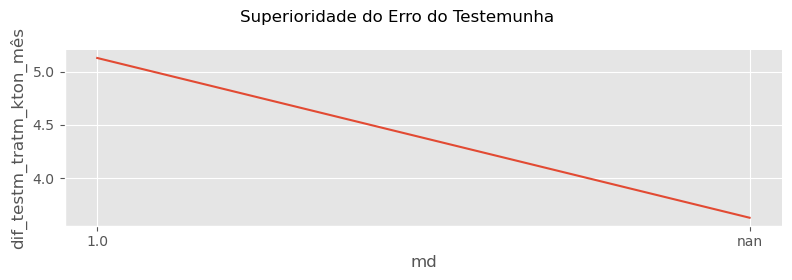

In [19]:
q.md=q.md.astype(str)
sns.relplot(data=q.groupby('md').dif_testm_tratm_kton_mês.mean().reset_index(),x='md',y='dif_testm_tratm_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)

In [20]:
md_pos=q.groupby('md').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').md.values[-1]
md_pos

'1.0'

In [21]:
md_neg=q.groupby('md').dif_testm_tratm_kton_mês.mean().reset_index().sort_values('dif_testm_tratm_kton_mês').md.values[0]
md_neg

'nan'

Filtra tratamentos desejados e separa os testes positivos e negativos

In [22]:
q_pos=q[(q.ad==ad_pos)&(q.md==md_pos)&(q.train_size_anos==train_size_anos_pos)&(q.CO_MES==mes_pos)]

In [23]:
q_neg=q[(q.ad==ad_neg)&(q.md==md_neg)&(q.train_size_anos==train_size_anos_neg)&(q.CO_MES==mes_neg)]

In [24]:
print(f"Nos testes positivos, o erro absoluto médio do Ho foi {round(q_pos.dif_testm_tratm_kton_mês.mean())} kton/mês a mais do que Ha.")

Nos testes positivos, o erro absoluto médio do Ho foi 13 kton/mês a mais do que Ha.


# Calculating the z-score and p-value

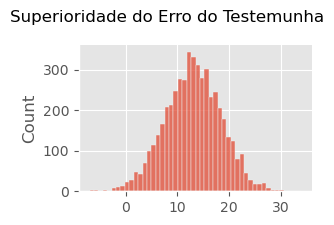

p_value=0.008


In [25]:
# Step 3. Repeat steps 1 & 2 many times, appending to a list
so_boot_distn = []
for i in range(5000):
    so_boot_distn.append(q_pos.sample(frac=1, replace=True)['dif_testm_tratm_kton_mês'].mean())

sns.displot(so_boot_distn,height=2,aspect=1.6).fig.suptitle(title,y=1.1)
plt.show()

m=np.mean(so_boot_distn)
s=np.std(so_boot_distn,ddof=1)

z_score=(0-m)/s

from scipy.stats import norm
p=round(norm.cdf(z_score,loc=0,scale=1),3)
print(f"p_value={p}")

In [26]:
if p<=alpha:
    print(f'Pelo método paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Pelo método paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Pelo método paramétrico, com significância de 0.05, "reject Ho".


> Apesar de termos rejeitada a hipótese nula com 0.05% de significância, visualmente se pode notar algumas anormalidades dos valores da reamostragem. Isso ocorre devido a baixo número de amostras originais.

In [27]:
print(f"O método determina que sejam de no mínimo 30 amostras originais.\n\
O número de amostras no teste positivo foi de {len(q_pos)}.")

O método determina que sejam de no mínimo 30 amostras originais.
O número de amostras no teste positivo foi de 12.


Nessa situação de baixo número de amostras originais,a alternativa são métodos não paramétricos, como o de Wilcoxon.

In [28]:
import pingouin

p_w=pingouin.wilcoxon(
    x=q_pos.erro_tratm,
    y=q_pos.erro_testm,
    alternative='less'
)
p_w

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,12.0,less,0.034177,-0.636364,0.732639


In [29]:
p=p_w['p-val'].values[0]

In [30]:
if p<=alpha:
    print(f'Por método não paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Por método não paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Por método não paramétrico, com significância de 0.05, "reject Ho".


# Conclusão

Na situação de realização do testes, com significância estatística de 0,05%, com método paramétrico e não-paramétrico, podemos afirmar que  os voumes das chuvas mensais influenciam as quantidades mensais desembacadas de fertilizantes e, por tanto, leva-los em conta pode proporcionar mais precisão nas previsões de chegada e, consequentemente, na precificação do produto em estoque.